# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 3.0MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

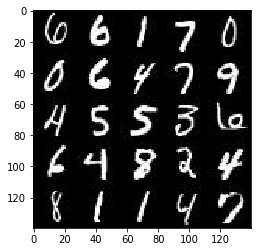

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

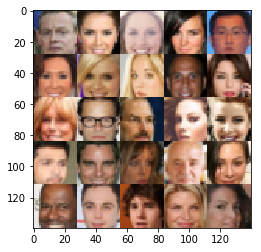

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images=tf.placeholder(tf.float32, shape=(None, image_width,image_height,image_channels))
    z_data=tf.placeholder(tf.float32, shape=(None,z_dim))
    learing_rate=tf.placeholder(tf.float32)
    return real_input_images, z_data, learing_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [49]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        #print(x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        #print(x2.shape)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        #print(x3.shape)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64 now
        #print(x4.shape)
        
        x5 = tf.layers.conv2d_transpose(x4,32, 5, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        # 28x28x64 now
        #print(x5.shape)

        logits = tf.layers.conv2d_transpose(x5,out_channel_dim, 5, strides=1, padding='same')        
        # 28x28x3 now
        #print(logits.shape)
        
        
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Create our input placeholders
    
    smooth=0.1

    # Build the model
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real,reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
    

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z,learing_rate=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss=model_loss(input_real, input_z, data_shape[3])
    d_train_opt,g_train_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    step=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                
                step+=1
                batch_images = batch_images * 2 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                op_d=sess.run(d_train_opt,feed_dict={input_real:batch_images,input_z:batch_z,learing_rate:learning_rate})
                op_g=sess.run(g_train_opt,feed_dict={input_real:batch_images,input_z:batch_z,learing_rate:learning_rate})
                if(step%100==0):
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                train_loss_d = sess.run(d_loss, {input_real:batch_images,input_z:batch_z,learing_rate:learning_rate})
                train_loss_g = g_loss.eval({input_real:batch_images,input_z:batch_z,learing_rate:learning_rate})
            
                print("Epoch {}/{} step {}...".format(epoch_i+1, epochs,step),
                "Discriminator Loss: {:.4f}...".format(train_loss_d),
                "Generator Loss: {:.4f}".format(train_loss_g))      
                # TODO: Train Model
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)        
         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 step 1... Discriminator Loss: 18.1392... Generator Loss: 0.0000
Epoch 1/2 step 2... Discriminator Loss: 2.3927... Generator Loss: 7.1963
Epoch 1/2 step 3... Discriminator Loss: 8.2114... Generator Loss: 0.0009
Epoch 1/2 step 4... Discriminator Loss: 0.6127... Generator Loss: 19.6720
Epoch 1/2 step 5... Discriminator Loss: 0.6531... Generator Loss: 17.9070
Epoch 1/2 step 6... Discriminator Loss: 0.7090... Generator Loss: 2.4860
Epoch 1/2 step 7... Discriminator Loss: 9.3724... Generator Loss: 0.0001
Epoch 1/2 step 8... Discriminator Loss: 6.5986... Generator Loss: 15.6609
Epoch 1/2 step 9... Discriminator Loss: 1.0355... Generator Loss: 0.9725
Epoch 1/2 step 10... Discriminator Loss: 0.4553... Generator Loss: 9.4970
Epoch 1/2 step 11... Discriminator Loss: 0.4903... Generator Loss: 5.9133
Epoch 1/2 step 12... Discriminator Loss: 0.9849... Generator Loss: 1.0179
Epoch 1/2 step 13... Discriminator Loss: 1.4603... Generator Loss: 13.9880
Epoch 1/2 step 14... Discriminator Loss: 0

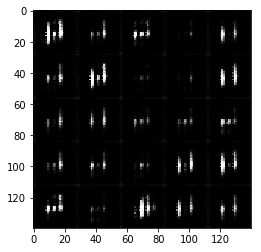

Epoch 1/2 step 100... Discriminator Loss: 0.7418... Generator Loss: 4.4657
Epoch 1/2 step 101... Discriminator Loss: 0.6312... Generator Loss: 2.0290
Epoch 1/2 step 102... Discriminator Loss: 0.5943... Generator Loss: 2.6425
Epoch 1/2 step 103... Discriminator Loss: 0.6723... Generator Loss: 2.3160
Epoch 1/2 step 104... Discriminator Loss: 1.7277... Generator Loss: 0.5805
Epoch 1/2 step 105... Discriminator Loss: 2.9472... Generator Loss: 6.6764
Epoch 1/2 step 106... Discriminator Loss: 1.1684... Generator Loss: 0.7939
Epoch 1/2 step 107... Discriminator Loss: 0.7480... Generator Loss: 4.1621
Epoch 1/2 step 108... Discriminator Loss: 0.8101... Generator Loss: 1.1871
Epoch 1/2 step 109... Discriminator Loss: 0.5580... Generator Loss: 3.2596
Epoch 1/2 step 110... Discriminator Loss: 0.6270... Generator Loss: 1.7474
Epoch 1/2 step 111... Discriminator Loss: 0.9020... Generator Loss: 1.0445
Epoch 1/2 step 112... Discriminator Loss: 1.1095... Generator Loss: 1.0319
Epoch 1/2 step 113... Dis

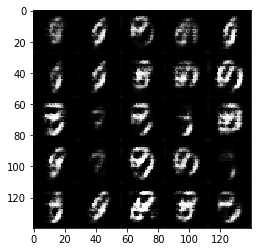

Epoch 1/2 step 200... Discriminator Loss: 0.9610... Generator Loss: 1.2131
Epoch 1/2 step 201... Discriminator Loss: 1.0852... Generator Loss: 1.2699
Epoch 1/2 step 202... Discriminator Loss: 1.0738... Generator Loss: 1.1469
Epoch 1/2 step 203... Discriminator Loss: 0.9458... Generator Loss: 1.5646
Epoch 1/2 step 204... Discriminator Loss: 1.0099... Generator Loss: 1.0355
Epoch 1/2 step 205... Discriminator Loss: 1.0022... Generator Loss: 2.3339
Epoch 1/2 step 206... Discriminator Loss: 1.3938... Generator Loss: 0.5485
Epoch 1/2 step 207... Discriminator Loss: 1.5459... Generator Loss: 2.7470
Epoch 1/2 step 208... Discriminator Loss: 1.9973... Generator Loss: 0.3172
Epoch 1/2 step 209... Discriminator Loss: 1.8624... Generator Loss: 2.0849
Epoch 1/2 step 210... Discriminator Loss: 1.6166... Generator Loss: 0.7009
Epoch 1/2 step 211... Discriminator Loss: 1.2941... Generator Loss: 1.3384
Epoch 1/2 step 212... Discriminator Loss: 1.2356... Generator Loss: 0.8617
Epoch 1/2 step 213... Dis

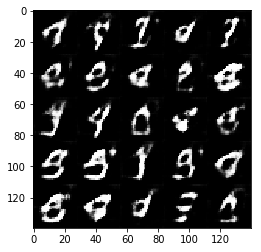

Epoch 1/2 step 300... Discriminator Loss: 1.0930... Generator Loss: 1.0362
Epoch 1/2 step 301... Discriminator Loss: 1.0518... Generator Loss: 1.2580
Epoch 1/2 step 302... Discriminator Loss: 1.2940... Generator Loss: 0.8903
Epoch 1/2 step 303... Discriminator Loss: 1.2708... Generator Loss: 1.2919
Epoch 1/2 step 304... Discriminator Loss: 1.2247... Generator Loss: 0.8028
Epoch 1/2 step 305... Discriminator Loss: 1.0072... Generator Loss: 1.7121
Epoch 1/2 step 306... Discriminator Loss: 0.9602... Generator Loss: 1.1978
Epoch 1/2 step 307... Discriminator Loss: 1.0919... Generator Loss: 0.8760
Epoch 1/2 step 308... Discriminator Loss: 1.1056... Generator Loss: 2.0970
Epoch 1/2 step 309... Discriminator Loss: 1.3637... Generator Loss: 0.7096
Epoch 1/2 step 310... Discriminator Loss: 1.3098... Generator Loss: 1.3319
Epoch 1/2 step 311... Discriminator Loss: 1.2412... Generator Loss: 0.8760
Epoch 1/2 step 312... Discriminator Loss: 1.1773... Generator Loss: 1.4811
Epoch 1/2 step 313... Dis

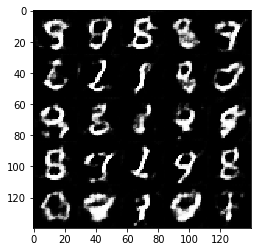

Epoch 1/2 step 400... Discriminator Loss: 1.2925... Generator Loss: 0.7375
Epoch 1/2 step 401... Discriminator Loss: 1.1803... Generator Loss: 1.1811
Epoch 1/2 step 402... Discriminator Loss: 1.1811... Generator Loss: 0.8460
Epoch 1/2 step 403... Discriminator Loss: 1.3391... Generator Loss: 1.0688
Epoch 1/2 step 404... Discriminator Loss: 1.2634... Generator Loss: 0.8037
Epoch 1/2 step 405... Discriminator Loss: 1.3144... Generator Loss: 0.8855
Epoch 1/2 step 406... Discriminator Loss: 1.1765... Generator Loss: 1.1098
Epoch 1/2 step 407... Discriminator Loss: 1.2867... Generator Loss: 0.8164
Epoch 1/2 step 408... Discriminator Loss: 1.3102... Generator Loss: 1.0275
Epoch 1/2 step 409... Discriminator Loss: 1.3228... Generator Loss: 0.7639
Epoch 1/2 step 410... Discriminator Loss: 1.2548... Generator Loss: 1.2883
Epoch 1/2 step 411... Discriminator Loss: 1.2885... Generator Loss: 0.6529
Epoch 1/2 step 412... Discriminator Loss: 1.3641... Generator Loss: 1.5387
Epoch 1/2 step 413... Dis

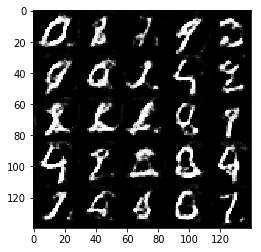

Epoch 1/2 step 500... Discriminator Loss: 1.4081... Generator Loss: 0.5740
Epoch 1/2 step 501... Discriminator Loss: 1.4367... Generator Loss: 0.9207
Epoch 1/2 step 502... Discriminator Loss: 1.3529... Generator Loss: 0.9167
Epoch 1/2 step 503... Discriminator Loss: 1.3158... Generator Loss: 0.7448
Epoch 1/2 step 504... Discriminator Loss: 1.3982... Generator Loss: 1.2165
Epoch 1/2 step 505... Discriminator Loss: 1.3259... Generator Loss: 0.6235
Epoch 1/2 step 506... Discriminator Loss: 1.2680... Generator Loss: 1.1450
Epoch 1/2 step 507... Discriminator Loss: 1.1809... Generator Loss: 0.8409
Epoch 1/2 step 508... Discriminator Loss: 1.2987... Generator Loss: 0.7944
Epoch 1/2 step 509... Discriminator Loss: 1.2439... Generator Loss: 1.1000
Epoch 1/2 step 510... Discriminator Loss: 1.2359... Generator Loss: 0.8093
Epoch 1/2 step 511... Discriminator Loss: 1.2419... Generator Loss: 0.9591
Epoch 1/2 step 512... Discriminator Loss: 1.2056... Generator Loss: 1.0441
Epoch 1/2 step 513... Dis

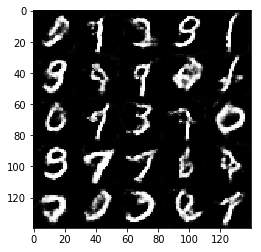

Epoch 1/2 step 600... Discriminator Loss: 1.2454... Generator Loss: 1.1897
Epoch 1/2 step 601... Discriminator Loss: 1.3183... Generator Loss: 0.8445
Epoch 1/2 step 602... Discriminator Loss: 1.4287... Generator Loss: 0.8156
Epoch 1/2 step 603... Discriminator Loss: 1.2880... Generator Loss: 0.8144
Epoch 1/2 step 604... Discriminator Loss: 1.2888... Generator Loss: 1.2520
Epoch 1/2 step 605... Discriminator Loss: 1.3004... Generator Loss: 0.6614
Epoch 1/2 step 606... Discriminator Loss: 1.2688... Generator Loss: 1.4042
Epoch 1/2 step 607... Discriminator Loss: 1.4204... Generator Loss: 0.5370
Epoch 1/2 step 608... Discriminator Loss: 1.3535... Generator Loss: 1.5124
Epoch 1/2 step 609... Discriminator Loss: 1.2946... Generator Loss: 0.5980
Epoch 1/2 step 610... Discriminator Loss: 1.2993... Generator Loss: 1.1478
Epoch 1/2 step 611... Discriminator Loss: 1.3757... Generator Loss: 0.6517
Epoch 1/2 step 612... Discriminator Loss: 1.2987... Generator Loss: 1.1456
Epoch 1/2 step 613... Dis

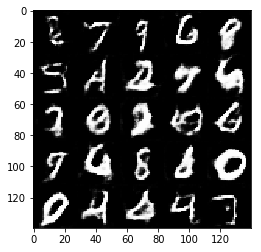

Epoch 1/2 step 700... Discriminator Loss: 1.3414... Generator Loss: 0.6470
Epoch 1/2 step 701... Discriminator Loss: 1.3442... Generator Loss: 1.2706
Epoch 1/2 step 702... Discriminator Loss: 1.3928... Generator Loss: 0.5845
Epoch 1/2 step 703... Discriminator Loss: 1.3545... Generator Loss: 1.2917
Epoch 1/2 step 704... Discriminator Loss: 1.4061... Generator Loss: 0.7185
Epoch 1/2 step 705... Discriminator Loss: 1.2738... Generator Loss: 0.9969
Epoch 1/2 step 706... Discriminator Loss: 1.3320... Generator Loss: 0.6808
Epoch 1/2 step 707... Discriminator Loss: 1.3647... Generator Loss: 1.1399
Epoch 1/2 step 708... Discriminator Loss: 1.3089... Generator Loss: 0.6789
Epoch 1/2 step 709... Discriminator Loss: 1.1953... Generator Loss: 1.0651
Epoch 1/2 step 710... Discriminator Loss: 1.3553... Generator Loss: 0.7114
Epoch 1/2 step 711... Discriminator Loss: 1.2490... Generator Loss: 0.9740
Epoch 1/2 step 712... Discriminator Loss: 1.2286... Generator Loss: 0.7912
Epoch 1/2 step 713... Dis

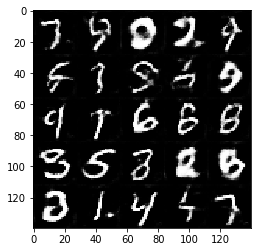

Epoch 1/2 step 800... Discriminator Loss: 1.3340... Generator Loss: 0.7281
Epoch 1/2 step 801... Discriminator Loss: 1.2396... Generator Loss: 0.9890
Epoch 1/2 step 802... Discriminator Loss: 1.2672... Generator Loss: 0.8061
Epoch 1/2 step 803... Discriminator Loss: 1.2266... Generator Loss: 0.9904
Epoch 1/2 step 804... Discriminator Loss: 1.3093... Generator Loss: 0.7978
Epoch 1/2 step 805... Discriminator Loss: 1.2185... Generator Loss: 1.0233
Epoch 1/2 step 806... Discriminator Loss: 1.2513... Generator Loss: 0.9981
Epoch 1/2 step 807... Discriminator Loss: 1.3441... Generator Loss: 0.7441
Epoch 1/2 step 808... Discriminator Loss: 1.2879... Generator Loss: 0.9373
Epoch 1/2 step 809... Discriminator Loss: 1.3001... Generator Loss: 0.8602
Epoch 1/2 step 810... Discriminator Loss: 1.2419... Generator Loss: 0.9502
Epoch 1/2 step 811... Discriminator Loss: 1.3172... Generator Loss: 0.7319
Epoch 1/2 step 812... Discriminator Loss: 1.3243... Generator Loss: 1.2996
Epoch 1/2 step 813... Dis

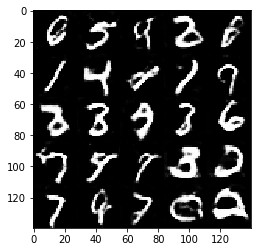

Epoch 1/2 step 900... Discriminator Loss: 1.4999... Generator Loss: 0.4830
Epoch 1/2 step 901... Discriminator Loss: 1.3321... Generator Loss: 1.0055
Epoch 1/2 step 902... Discriminator Loss: 1.2555... Generator Loss: 0.7974
Epoch 1/2 step 903... Discriminator Loss: 1.2720... Generator Loss: 0.9850
Epoch 1/2 step 904... Discriminator Loss: 1.3760... Generator Loss: 0.6064
Epoch 1/2 step 905... Discriminator Loss: 1.4256... Generator Loss: 1.3618
Epoch 1/2 step 906... Discriminator Loss: 1.4909... Generator Loss: 0.4617
Epoch 1/2 step 907... Discriminator Loss: 1.3323... Generator Loss: 1.3406
Epoch 1/2 step 908... Discriminator Loss: 1.3201... Generator Loss: 0.6186
Epoch 1/2 step 909... Discriminator Loss: 1.3416... Generator Loss: 0.8956
Epoch 1/2 step 910... Discriminator Loss: 1.3499... Generator Loss: 0.8117
Epoch 1/2 step 911... Discriminator Loss: 1.2123... Generator Loss: 0.9918
Epoch 1/2 step 912... Discriminator Loss: 1.2690... Generator Loss: 0.8215
Epoch 1/2 step 913... Dis

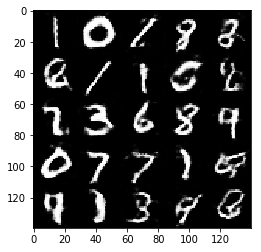

Epoch 2/2 step 1000... Discriminator Loss: 1.3862... Generator Loss: 1.0329
Epoch 2/2 step 1001... Discriminator Loss: 1.3231... Generator Loss: 0.6702
Epoch 2/2 step 1002... Discriminator Loss: 1.2356... Generator Loss: 1.1549
Epoch 2/2 step 1003... Discriminator Loss: 1.3645... Generator Loss: 0.5631
Epoch 2/2 step 1004... Discriminator Loss: 1.3325... Generator Loss: 1.4754
Epoch 2/2 step 1005... Discriminator Loss: 1.3729... Generator Loss: 0.5530
Epoch 2/2 step 1006... Discriminator Loss: 1.3342... Generator Loss: 1.1886
Epoch 2/2 step 1007... Discriminator Loss: 1.2817... Generator Loss: 0.6744
Epoch 2/2 step 1008... Discriminator Loss: 1.2805... Generator Loss: 1.1540
Epoch 2/2 step 1009... Discriminator Loss: 1.3118... Generator Loss: 0.6758
Epoch 2/2 step 1010... Discriminator Loss: 1.3194... Generator Loss: 0.9874
Epoch 2/2 step 1011... Discriminator Loss: 1.2941... Generator Loss: 0.7616
Epoch 2/2 step 1012... Discriminator Loss: 1.2953... Generator Loss: 0.9368
Epoch 2/2 st

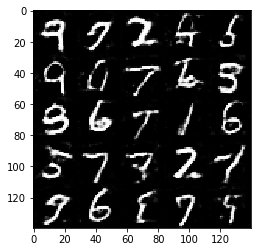

Epoch 2/2 step 1100... Discriminator Loss: 1.4058... Generator Loss: 0.8178
Epoch 2/2 step 1101... Discriminator Loss: 1.2880... Generator Loss: 0.7524
Epoch 2/2 step 1102... Discriminator Loss: 1.2739... Generator Loss: 1.0851
Epoch 2/2 step 1103... Discriminator Loss: 1.2862... Generator Loss: 0.6686
Epoch 2/2 step 1104... Discriminator Loss: 1.2768... Generator Loss: 1.1414
Epoch 2/2 step 1105... Discriminator Loss: 1.3784... Generator Loss: 0.6003
Epoch 2/2 step 1106... Discriminator Loss: 1.3540... Generator Loss: 1.3310
Epoch 2/2 step 1107... Discriminator Loss: 1.3552... Generator Loss: 0.5438
Epoch 2/2 step 1108... Discriminator Loss: 1.4211... Generator Loss: 1.3393
Epoch 2/2 step 1109... Discriminator Loss: 1.4287... Generator Loss: 0.5374
Epoch 2/2 step 1110... Discriminator Loss: 1.3012... Generator Loss: 1.3433
Epoch 2/2 step 1111... Discriminator Loss: 1.3077... Generator Loss: 0.6515
Epoch 2/2 step 1112... Discriminator Loss: 1.2958... Generator Loss: 1.0041
Epoch 2/2 st

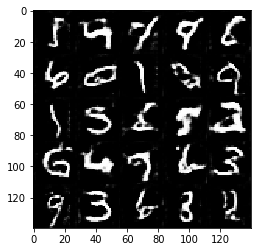

Epoch 2/2 step 1200... Discriminator Loss: 1.4886... Generator Loss: 0.4384
Epoch 2/2 step 1201... Discriminator Loss: 1.6312... Generator Loss: 1.6315
Epoch 2/2 step 1202... Discriminator Loss: 1.4713... Generator Loss: 0.4879
Epoch 2/2 step 1203... Discriminator Loss: 1.3609... Generator Loss: 1.1964
Epoch 2/2 step 1204... Discriminator Loss: 1.3284... Generator Loss: 0.6964
Epoch 2/2 step 1205... Discriminator Loss: 1.2741... Generator Loss: 0.9050
Epoch 2/2 step 1206... Discriminator Loss: 1.2990... Generator Loss: 0.8799
Epoch 2/2 step 1207... Discriminator Loss: 1.3097... Generator Loss: 0.7697
Epoch 2/2 step 1208... Discriminator Loss: 1.3041... Generator Loss: 0.8685
Epoch 2/2 step 1209... Discriminator Loss: 1.2638... Generator Loss: 0.8200
Epoch 2/2 step 1210... Discriminator Loss: 1.2659... Generator Loss: 0.8926
Epoch 2/2 step 1211... Discriminator Loss: 1.4077... Generator Loss: 0.6452
Epoch 2/2 step 1212... Discriminator Loss: 1.3898... Generator Loss: 1.1493
Epoch 2/2 st

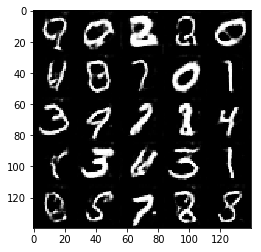

Epoch 2/2 step 1300... Discriminator Loss: 1.2971... Generator Loss: 0.8975
Epoch 2/2 step 1301... Discriminator Loss: 1.3144... Generator Loss: 0.8330
Epoch 2/2 step 1302... Discriminator Loss: 1.3695... Generator Loss: 0.6593
Epoch 2/2 step 1303... Discriminator Loss: 1.3165... Generator Loss: 1.1646
Epoch 2/2 step 1304... Discriminator Loss: 1.3282... Generator Loss: 0.6326
Epoch 2/2 step 1305... Discriminator Loss: 1.3168... Generator Loss: 1.1912
Epoch 2/2 step 1306... Discriminator Loss: 1.4015... Generator Loss: 0.5225
Epoch 2/2 step 1307... Discriminator Loss: 1.4610... Generator Loss: 1.4651
Epoch 2/2 step 1308... Discriminator Loss: 1.3854... Generator Loss: 0.5577
Epoch 2/2 step 1309... Discriminator Loss: 1.3026... Generator Loss: 1.1442
Epoch 2/2 step 1310... Discriminator Loss: 1.2977... Generator Loss: 0.7055
Epoch 2/2 step 1311... Discriminator Loss: 1.2588... Generator Loss: 1.0341
Epoch 2/2 step 1312... Discriminator Loss: 1.2619... Generator Loss: 0.7696
Epoch 2/2 st

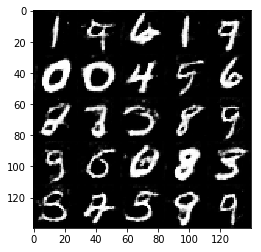

Epoch 2/2 step 1400... Discriminator Loss: 1.4397... Generator Loss: 1.3562
Epoch 2/2 step 1401... Discriminator Loss: 1.4361... Generator Loss: 0.5360
Epoch 2/2 step 1402... Discriminator Loss: 1.4240... Generator Loss: 1.1913
Epoch 2/2 step 1403... Discriminator Loss: 1.3514... Generator Loss: 0.6952
Epoch 2/2 step 1404... Discriminator Loss: 1.3013... Generator Loss: 0.8853
Epoch 2/2 step 1405... Discriminator Loss: 1.3219... Generator Loss: 0.8919
Epoch 2/2 step 1406... Discriminator Loss: 1.3372... Generator Loss: 0.8472
Epoch 2/2 step 1407... Discriminator Loss: 1.3006... Generator Loss: 0.7049
Epoch 2/2 step 1408... Discriminator Loss: 1.2992... Generator Loss: 1.0134
Epoch 2/2 step 1409... Discriminator Loss: 1.2734... Generator Loss: 0.7722
Epoch 2/2 step 1410... Discriminator Loss: 1.2874... Generator Loss: 0.9821
Epoch 2/2 step 1411... Discriminator Loss: 1.2808... Generator Loss: 0.7806
Epoch 2/2 step 1412... Discriminator Loss: 1.2227... Generator Loss: 0.8726
Epoch 2/2 st

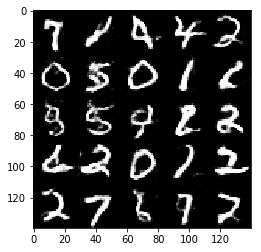

Epoch 2/2 step 1500... Discriminator Loss: 1.2949... Generator Loss: 0.7073
Epoch 2/2 step 1501... Discriminator Loss: 1.2992... Generator Loss: 0.9864
Epoch 2/2 step 1502... Discriminator Loss: 1.3091... Generator Loss: 0.7281
Epoch 2/2 step 1503... Discriminator Loss: 1.3287... Generator Loss: 0.8107
Epoch 2/2 step 1504... Discriminator Loss: 1.3282... Generator Loss: 0.9945
Epoch 2/2 step 1505... Discriminator Loss: 1.3192... Generator Loss: 0.6978
Epoch 2/2 step 1506... Discriminator Loss: 1.3146... Generator Loss: 0.9683
Epoch 2/2 step 1507... Discriminator Loss: 1.2900... Generator Loss: 0.7915
Epoch 2/2 step 1508... Discriminator Loss: 1.3095... Generator Loss: 0.7629
Epoch 2/2 step 1509... Discriminator Loss: 1.2992... Generator Loss: 1.0087
Epoch 2/2 step 1510... Discriminator Loss: 1.3458... Generator Loss: 0.5972
Epoch 2/2 step 1511... Discriminator Loss: 1.3519... Generator Loss: 1.0856
Epoch 2/2 step 1512... Discriminator Loss: 1.2717... Generator Loss: 0.7389
Epoch 2/2 st

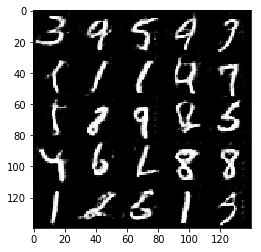

Epoch 2/2 step 1600... Discriminator Loss: 1.3478... Generator Loss: 0.8766
Epoch 2/2 step 1601... Discriminator Loss: 1.3669... Generator Loss: 0.7204
Epoch 2/2 step 1602... Discriminator Loss: 1.2447... Generator Loss: 0.9142
Epoch 2/2 step 1603... Discriminator Loss: 1.3498... Generator Loss: 0.8534
Epoch 2/2 step 1604... Discriminator Loss: 1.3128... Generator Loss: 0.8707
Epoch 2/2 step 1605... Discriminator Loss: 1.2739... Generator Loss: 0.7284
Epoch 2/2 step 1606... Discriminator Loss: 1.2808... Generator Loss: 1.0763
Epoch 2/2 step 1607... Discriminator Loss: 1.3351... Generator Loss: 0.6550
Epoch 2/2 step 1608... Discriminator Loss: 1.3107... Generator Loss: 1.0078
Epoch 2/2 step 1609... Discriminator Loss: 1.3589... Generator Loss: 0.5968
Epoch 2/2 step 1610... Discriminator Loss: 1.3427... Generator Loss: 1.3780
Epoch 2/2 step 1611... Discriminator Loss: 1.4377... Generator Loss: 0.5173
Epoch 2/2 step 1612... Discriminator Loss: 1.4188... Generator Loss: 1.3241
Epoch 2/2 st

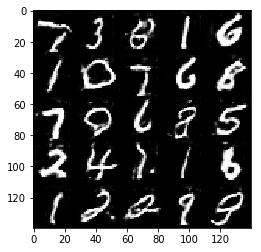

Epoch 2/2 step 1700... Discriminator Loss: 1.2865... Generator Loss: 0.9107
Epoch 2/2 step 1701... Discriminator Loss: 1.2401... Generator Loss: 0.7922
Epoch 2/2 step 1702... Discriminator Loss: 1.2901... Generator Loss: 1.0153
Epoch 2/2 step 1703... Discriminator Loss: 1.2867... Generator Loss: 0.6867
Epoch 2/2 step 1704... Discriminator Loss: 1.3026... Generator Loss: 1.1594
Epoch 2/2 step 1705... Discriminator Loss: 1.4752... Generator Loss: 0.4860
Epoch 2/2 step 1706... Discriminator Loss: 1.4076... Generator Loss: 1.2019
Epoch 2/2 step 1707... Discriminator Loss: 1.3540... Generator Loss: 0.6113
Epoch 2/2 step 1708... Discriminator Loss: 1.3208... Generator Loss: 0.9335
Epoch 2/2 step 1709... Discriminator Loss: 1.3045... Generator Loss: 0.7369
Epoch 2/2 step 1710... Discriminator Loss: 1.3124... Generator Loss: 0.8836
Epoch 2/2 step 1711... Discriminator Loss: 1.3664... Generator Loss: 0.8282
Epoch 2/2 step 1712... Discriminator Loss: 1.2531... Generator Loss: 0.8320
Epoch 2/2 st

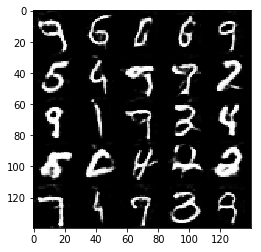

Epoch 2/2 step 1800... Discriminator Loss: 1.3169... Generator Loss: 0.7288
Epoch 2/2 step 1801... Discriminator Loss: 1.3239... Generator Loss: 0.8592
Epoch 2/2 step 1802... Discriminator Loss: 1.2917... Generator Loss: 0.9873
Epoch 2/2 step 1803... Discriminator Loss: 1.3729... Generator Loss: 0.5924
Epoch 2/2 step 1804... Discriminator Loss: 1.2865... Generator Loss: 1.2213
Epoch 2/2 step 1805... Discriminator Loss: 1.3649... Generator Loss: 0.5731
Epoch 2/2 step 1806... Discriminator Loss: 1.3986... Generator Loss: 0.9748
Epoch 2/2 step 1807... Discriminator Loss: 1.3319... Generator Loss: 0.8731
Epoch 2/2 step 1808... Discriminator Loss: 1.3225... Generator Loss: 0.6252
Epoch 2/2 step 1809... Discriminator Loss: 1.2620... Generator Loss: 1.1987
Epoch 2/2 step 1810... Discriminator Loss: 1.4384... Generator Loss: 0.5400
Epoch 2/2 step 1811... Discriminator Loss: 1.3529... Generator Loss: 1.3082
Epoch 2/2 step 1812... Discriminator Loss: 1.3364... Generator Loss: 0.6422
Epoch 2/2 st

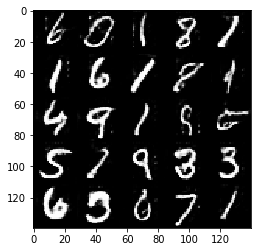

In [55]:

batch_size = 64
z_dim = 50
learning_rate = 0.001
beta1 = 0.4
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 step 1... Discriminator Loss: 19.0916... Generator Loss: 0.0000
Epoch 1/1 step 2... Discriminator Loss: 2.4309... Generator Loss: 0.2304
Epoch 1/1 step 3... Discriminator Loss: 8.9187... Generator Loss: 16.2199
Epoch 1/1 step 4... Discriminator Loss: 10.1511... Generator Loss: 0.0002
Epoch 1/1 step 5... Discriminator Loss: 1.0648... Generator Loss: 10.3784
Epoch 1/1 step 6... Discriminator Loss: 0.6642... Generator Loss: 3.0986
Epoch 1/1 step 7... Discriminator Loss: 3.0284... Generator Loss: 0.0922
Epoch 1/1 step 8... Discriminator Loss: 3.2153... Generator Loss: 18.8070
Epoch 1/1 step 9... Discriminator Loss: 1.6160... Generator Loss: 12.0503
Epoch 1/1 step 10... Discriminator Loss: 3.3134... Generator Loss: 0.1008
Epoch 1/1 step 11... Discriminator Loss: 1.2522... Generator Loss: 14.7866
Epoch 1/1 step 12... Discriminator Loss: 1.1307... Generator Loss: 13.7923
Epoch 1/1 step 13... Discriminator Loss: 0.7127... Generator Loss: 7.7899
Epoch 1/1 step 14... Discriminator Loss

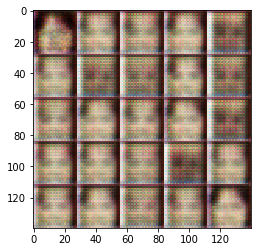

Epoch 1/1 step 100... Discriminator Loss: 1.6117... Generator Loss: 1.7238
Epoch 1/1 step 101... Discriminator Loss: 1.4969... Generator Loss: 0.5182
Epoch 1/1 step 102... Discriminator Loss: 1.1105... Generator Loss: 1.5889
Epoch 1/1 step 103... Discriminator Loss: 1.2494... Generator Loss: 1.0455
Epoch 1/1 step 104... Discriminator Loss: 1.2933... Generator Loss: 0.9358
Epoch 1/1 step 105... Discriminator Loss: 1.2028... Generator Loss: 1.1460
Epoch 1/1 step 106... Discriminator Loss: 1.2145... Generator Loss: 0.7058
Epoch 1/1 step 107... Discriminator Loss: 1.2763... Generator Loss: 1.0243
Epoch 1/1 step 108... Discriminator Loss: 1.5344... Generator Loss: 0.6364
Epoch 1/1 step 109... Discriminator Loss: 1.5473... Generator Loss: 1.9499
Epoch 1/1 step 110... Discriminator Loss: 1.3413... Generator Loss: 0.6781
Epoch 1/1 step 111... Discriminator Loss: 1.0531... Generator Loss: 0.8881
Epoch 1/1 step 112... Discriminator Loss: 1.0947... Generator Loss: 1.3047
Epoch 1/1 step 113... Dis

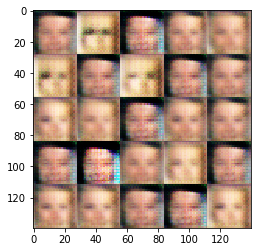

Epoch 1/1 step 200... Discriminator Loss: 1.5352... Generator Loss: 1.0662
Epoch 1/1 step 201... Discriminator Loss: 1.2423... Generator Loss: 0.8849
Epoch 1/1 step 202... Discriminator Loss: 1.1428... Generator Loss: 1.6508
Epoch 1/1 step 203... Discriminator Loss: 1.2633... Generator Loss: 0.8012
Epoch 1/1 step 204... Discriminator Loss: 1.5850... Generator Loss: 1.4877
Epoch 1/1 step 205... Discriminator Loss: 1.4930... Generator Loss: 0.5252
Epoch 1/1 step 206... Discriminator Loss: 1.4041... Generator Loss: 1.0687
Epoch 1/1 step 207... Discriminator Loss: 1.2794... Generator Loss: 0.9478
Epoch 1/1 step 208... Discriminator Loss: 1.0490... Generator Loss: 0.8902
Epoch 1/1 step 209... Discriminator Loss: 1.0093... Generator Loss: 1.2717
Epoch 1/1 step 210... Discriminator Loss: 1.1982... Generator Loss: 0.7996
Epoch 1/1 step 211... Discriminator Loss: 1.2964... Generator Loss: 1.0111
Epoch 1/1 step 212... Discriminator Loss: 1.3569... Generator Loss: 0.9458
Epoch 1/1 step 213... Dis

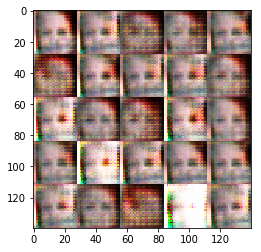

Epoch 1/1 step 300... Discriminator Loss: 1.2761... Generator Loss: 2.1997
Epoch 1/1 step 301... Discriminator Loss: 0.9966... Generator Loss: 1.2160
Epoch 1/1 step 302... Discriminator Loss: 1.9368... Generator Loss: 0.3226
Epoch 1/1 step 303... Discriminator Loss: 2.2331... Generator Loss: 2.5887
Epoch 1/1 step 304... Discriminator Loss: 1.3690... Generator Loss: 0.7112
Epoch 1/1 step 305... Discriminator Loss: 2.1186... Generator Loss: 0.3554
Epoch 1/1 step 306... Discriminator Loss: 2.0765... Generator Loss: 2.9817
Epoch 1/1 step 307... Discriminator Loss: 1.3966... Generator Loss: 1.5964
Epoch 1/1 step 308... Discriminator Loss: 1.4165... Generator Loss: 0.6392
Epoch 1/1 step 309... Discriminator Loss: 1.0188... Generator Loss: 0.9008
Epoch 1/1 step 310... Discriminator Loss: 1.0169... Generator Loss: 1.1467
Epoch 1/1 step 311... Discriminator Loss: 1.3130... Generator Loss: 1.0463
Epoch 1/1 step 312... Discriminator Loss: 1.3991... Generator Loss: 1.0378
Epoch 1/1 step 313... Dis

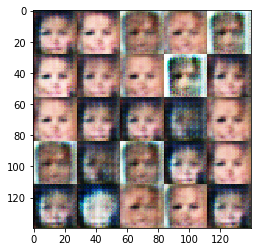

Epoch 1/1 step 400... Discriminator Loss: 1.8956... Generator Loss: 0.3893
Epoch 1/1 step 401... Discriminator Loss: 1.7603... Generator Loss: 2.2936
Epoch 1/1 step 402... Discriminator Loss: 0.8818... Generator Loss: 1.2255
Epoch 1/1 step 403... Discriminator Loss: 1.9425... Generator Loss: 0.2839
Epoch 1/1 step 404... Discriminator Loss: 1.4313... Generator Loss: 1.7478
Epoch 1/1 step 405... Discriminator Loss: 1.2388... Generator Loss: 1.2069
Epoch 1/1 step 406... Discriminator Loss: 1.3670... Generator Loss: 0.6387
Epoch 1/1 step 407... Discriminator Loss: 1.1521... Generator Loss: 0.9560
Epoch 1/1 step 408... Discriminator Loss: 1.2807... Generator Loss: 2.2967
Epoch 1/1 step 409... Discriminator Loss: 1.0192... Generator Loss: 1.0864
Epoch 1/1 step 410... Discriminator Loss: 1.0509... Generator Loss: 0.8726
Epoch 1/1 step 411... Discriminator Loss: 0.8531... Generator Loss: 1.4308
Epoch 1/1 step 412... Discriminator Loss: 1.2203... Generator Loss: 0.7713
Epoch 1/1 step 413... Dis

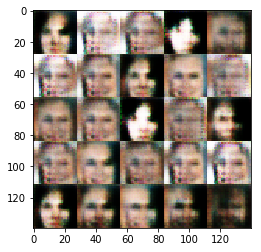

Epoch 1/1 step 500... Discriminator Loss: 1.7176... Generator Loss: 0.3858
Epoch 1/1 step 501... Discriminator Loss: 1.4421... Generator Loss: 1.5224
Epoch 1/1 step 502... Discriminator Loss: 1.2486... Generator Loss: 1.0325
Epoch 1/1 step 503... Discriminator Loss: 1.0856... Generator Loss: 0.9811
Epoch 1/1 step 504... Discriminator Loss: 1.1597... Generator Loss: 0.8107
Epoch 1/1 step 505... Discriminator Loss: 1.2069... Generator Loss: 0.9700
Epoch 1/1 step 506... Discriminator Loss: 1.2562... Generator Loss: 1.1368
Epoch 1/1 step 507... Discriminator Loss: 1.2436... Generator Loss: 0.6800
Epoch 1/1 step 508... Discriminator Loss: 1.4336... Generator Loss: 1.4814
Epoch 1/1 step 509... Discriminator Loss: 1.6045... Generator Loss: 0.5120
Epoch 1/1 step 510... Discriminator Loss: 1.7809... Generator Loss: 1.1770
Epoch 1/1 step 511... Discriminator Loss: 1.6041... Generator Loss: 0.6307
Epoch 1/1 step 512... Discriminator Loss: 1.5887... Generator Loss: 2.0867
Epoch 1/1 step 513... Dis

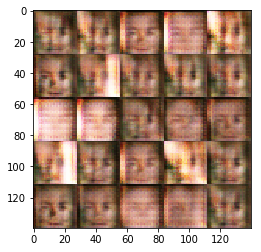

Epoch 1/1 step 600... Discriminator Loss: 1.2477... Generator Loss: 0.8612
Epoch 1/1 step 601... Discriminator Loss: 1.1123... Generator Loss: 0.8668
Epoch 1/1 step 602... Discriminator Loss: 0.9280... Generator Loss: 1.4358
Epoch 1/1 step 603... Discriminator Loss: 0.9974... Generator Loss: 1.2366
Epoch 1/1 step 604... Discriminator Loss: 1.1395... Generator Loss: 0.8701
Epoch 1/1 step 605... Discriminator Loss: 1.0074... Generator Loss: 1.2734
Epoch 1/1 step 606... Discriminator Loss: 1.1489... Generator Loss: 0.8624
Epoch 1/1 step 607... Discriminator Loss: 1.3314... Generator Loss: 0.5945
Epoch 1/1 step 608... Discriminator Loss: 1.5311... Generator Loss: 1.6183
Epoch 1/1 step 609... Discriminator Loss: 1.4442... Generator Loss: 0.6006
Epoch 1/1 step 610... Discriminator Loss: 1.3590... Generator Loss: 1.0887
Epoch 1/1 step 611... Discriminator Loss: 1.5280... Generator Loss: 0.6811
Epoch 1/1 step 612... Discriminator Loss: 1.4749... Generator Loss: 1.1662
Epoch 1/1 step 613... Dis

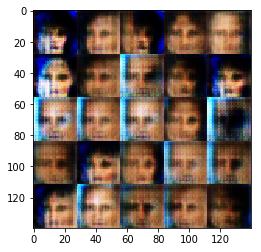

Epoch 1/1 step 700... Discriminator Loss: 1.0210... Generator Loss: 1.0253
Epoch 1/1 step 701... Discriminator Loss: 1.0474... Generator Loss: 1.0690
Epoch 1/1 step 702... Discriminator Loss: 1.0741... Generator Loss: 1.3614
Epoch 1/1 step 703... Discriminator Loss: 1.1458... Generator Loss: 0.7892
Epoch 1/1 step 704... Discriminator Loss: 1.6842... Generator Loss: 2.8112
Epoch 1/1 step 705... Discriminator Loss: 1.2789... Generator Loss: 0.5625
Epoch 1/1 step 706... Discriminator Loss: 1.2193... Generator Loss: 2.5237
Epoch 1/1 step 707... Discriminator Loss: 1.4284... Generator Loss: 0.4893
Epoch 1/1 step 708... Discriminator Loss: 1.3749... Generator Loss: 1.4333
Epoch 1/1 step 709... Discriminator Loss: 1.3677... Generator Loss: 0.6473
Epoch 1/1 step 710... Discriminator Loss: 1.3685... Generator Loss: 0.9883
Epoch 1/1 step 711... Discriminator Loss: 1.4055... Generator Loss: 1.0169
Epoch 1/1 step 712... Discriminator Loss: 1.2646... Generator Loss: 0.8807
Epoch 1/1 step 713... Dis

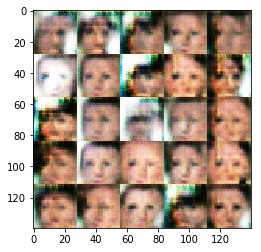

Epoch 1/1 step 800... Discriminator Loss: 1.1806... Generator Loss: 0.9867
Epoch 1/1 step 801... Discriminator Loss: 1.0839... Generator Loss: 1.1084
Epoch 1/1 step 802... Discriminator Loss: 1.1558... Generator Loss: 0.8809
Epoch 1/1 step 803... Discriminator Loss: 1.3187... Generator Loss: 1.1219
Epoch 1/1 step 804... Discriminator Loss: 1.1534... Generator Loss: 0.8926
Epoch 1/1 step 805... Discriminator Loss: 1.1618... Generator Loss: 1.0426
Epoch 1/1 step 806... Discriminator Loss: 1.2285... Generator Loss: 0.8359
Epoch 1/1 step 807... Discriminator Loss: 1.3775... Generator Loss: 0.8589
Epoch 1/1 step 808... Discriminator Loss: 1.3380... Generator Loss: 0.8172
Epoch 1/1 step 809... Discriminator Loss: 1.3002... Generator Loss: 0.9737
Epoch 1/1 step 810... Discriminator Loss: 1.3321... Generator Loss: 0.8653
Epoch 1/1 step 811... Discriminator Loss: 1.1427... Generator Loss: 1.0519
Epoch 1/1 step 812... Discriminator Loss: 1.0622... Generator Loss: 1.2394
Epoch 1/1 step 813... Dis

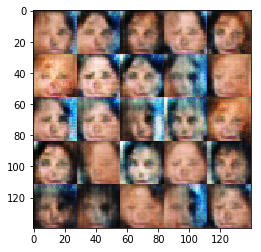

Epoch 1/1 step 900... Discriminator Loss: 1.2807... Generator Loss: 0.9893
Epoch 1/1 step 901... Discriminator Loss: 1.1837... Generator Loss: 0.8555
Epoch 1/1 step 902... Discriminator Loss: 1.2055... Generator Loss: 0.8735
Epoch 1/1 step 903... Discriminator Loss: 1.2792... Generator Loss: 1.3339
Epoch 1/1 step 904... Discriminator Loss: 1.5413... Generator Loss: 0.4438
Epoch 1/1 step 905... Discriminator Loss: 1.4423... Generator Loss: 1.2915
Epoch 1/1 step 906... Discriminator Loss: 1.3563... Generator Loss: 0.6958
Epoch 1/1 step 907... Discriminator Loss: 1.3403... Generator Loss: 1.1555
Epoch 1/1 step 908... Discriminator Loss: 1.4714... Generator Loss: 0.5548
Epoch 1/1 step 909... Discriminator Loss: 1.3457... Generator Loss: 1.3409
Epoch 1/1 step 910... Discriminator Loss: 1.1497... Generator Loss: 0.8512
Epoch 1/1 step 911... Discriminator Loss: 1.1525... Generator Loss: 0.8815
Epoch 1/1 step 912... Discriminator Loss: 1.1372... Generator Loss: 1.0916
Epoch 1/1 step 913... Dis

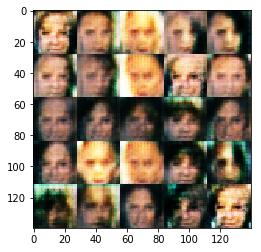

Epoch 1/1 step 1000... Discriminator Loss: 1.3775... Generator Loss: 0.9189
Epoch 1/1 step 1001... Discriminator Loss: 1.4633... Generator Loss: 0.6432
Epoch 1/1 step 1002... Discriminator Loss: 1.2779... Generator Loss: 1.0796
Epoch 1/1 step 1003... Discriminator Loss: 1.3779... Generator Loss: 0.8414
Epoch 1/1 step 1004... Discriminator Loss: 1.5453... Generator Loss: 0.6477
Epoch 1/1 step 1005... Discriminator Loss: 1.3608... Generator Loss: 0.9506
Epoch 1/1 step 1006... Discriminator Loss: 1.3065... Generator Loss: 0.8266
Epoch 1/1 step 1007... Discriminator Loss: 1.3071... Generator Loss: 0.9328
Epoch 1/1 step 1008... Discriminator Loss: 1.1587... Generator Loss: 0.9778
Epoch 1/1 step 1009... Discriminator Loss: 1.3571... Generator Loss: 0.8660
Epoch 1/1 step 1010... Discriminator Loss: 1.3787... Generator Loss: 0.9405
Epoch 1/1 step 1011... Discriminator Loss: 1.3950... Generator Loss: 0.8531
Epoch 1/1 step 1012... Discriminator Loss: 1.2166... Generator Loss: 0.9232
Epoch 1/1 st

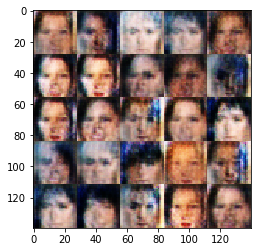

Epoch 1/1 step 1100... Discriminator Loss: 1.2751... Generator Loss: 0.6746
Epoch 1/1 step 1101... Discriminator Loss: 1.3930... Generator Loss: 1.0730
Epoch 1/1 step 1102... Discriminator Loss: 1.3856... Generator Loss: 0.7285
Epoch 1/1 step 1103... Discriminator Loss: 1.2802... Generator Loss: 0.9447
Epoch 1/1 step 1104... Discriminator Loss: 1.1786... Generator Loss: 0.9824
Epoch 1/1 step 1105... Discriminator Loss: 1.3379... Generator Loss: 0.9903
Epoch 1/1 step 1106... Discriminator Loss: 1.6355... Generator Loss: 0.5034
Epoch 1/1 step 1107... Discriminator Loss: 1.5945... Generator Loss: 1.4160
Epoch 1/1 step 1108... Discriminator Loss: 1.4060... Generator Loss: 0.5778
Epoch 1/1 step 1109... Discriminator Loss: 1.3068... Generator Loss: 0.7441
Epoch 1/1 step 1110... Discriminator Loss: 1.3085... Generator Loss: 1.2138
Epoch 1/1 step 1111... Discriminator Loss: 1.1696... Generator Loss: 0.9552
Epoch 1/1 step 1112... Discriminator Loss: 1.1245... Generator Loss: 1.0058
Epoch 1/1 st

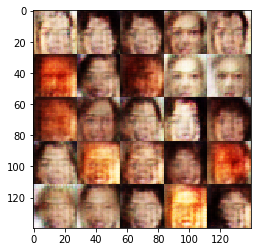

Epoch 1/1 step 1200... Discriminator Loss: 1.2126... Generator Loss: 1.0380
Epoch 1/1 step 1201... Discriminator Loss: 1.2890... Generator Loss: 0.8428
Epoch 1/1 step 1202... Discriminator Loss: 1.2857... Generator Loss: 0.7299
Epoch 1/1 step 1203... Discriminator Loss: 1.3335... Generator Loss: 0.9240
Epoch 1/1 step 1204... Discriminator Loss: 1.2238... Generator Loss: 0.9495
Epoch 1/1 step 1205... Discriminator Loss: 1.1469... Generator Loss: 1.0834
Epoch 1/1 step 1206... Discriminator Loss: 1.2895... Generator Loss: 0.6342
Epoch 1/1 step 1207... Discriminator Loss: 1.3361... Generator Loss: 1.4385
Epoch 1/1 step 1208... Discriminator Loss: 1.5872... Generator Loss: 0.4418
Epoch 1/1 step 1209... Discriminator Loss: 1.3552... Generator Loss: 1.4753
Epoch 1/1 step 1210... Discriminator Loss: 1.5352... Generator Loss: 0.4460
Epoch 1/1 step 1211... Discriminator Loss: 1.5374... Generator Loss: 1.6770
Epoch 1/1 step 1212... Discriminator Loss: 1.4339... Generator Loss: 0.5929
Epoch 1/1 st

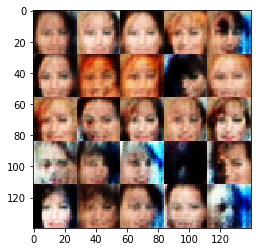

Epoch 1/1 step 1300... Discriminator Loss: 1.1178... Generator Loss: 1.2900
Epoch 1/1 step 1301... Discriminator Loss: 1.4901... Generator Loss: 0.4841
Epoch 1/1 step 1302... Discriminator Loss: 1.4129... Generator Loss: 1.6194
Epoch 1/1 step 1303... Discriminator Loss: 1.6362... Generator Loss: 0.4378
Epoch 1/1 step 1304... Discriminator Loss: 1.7048... Generator Loss: 1.5763
Epoch 1/1 step 1305... Discriminator Loss: 1.6831... Generator Loss: 0.6200
Epoch 1/1 step 1306... Discriminator Loss: 1.5462... Generator Loss: 0.5737
Epoch 1/1 step 1307... Discriminator Loss: 1.4645... Generator Loss: 0.7263
Epoch 1/1 step 1308... Discriminator Loss: 1.3630... Generator Loss: 1.2885
Epoch 1/1 step 1309... Discriminator Loss: 1.3226... Generator Loss: 0.5765
Epoch 1/1 step 1310... Discriminator Loss: 1.3528... Generator Loss: 1.4138
Epoch 1/1 step 1311... Discriminator Loss: 1.3931... Generator Loss: 0.6342
Epoch 1/1 step 1312... Discriminator Loss: 1.2433... Generator Loss: 0.9750
Epoch 1/1 st

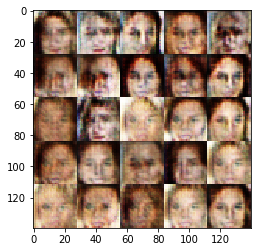

Epoch 1/1 step 1400... Discriminator Loss: 1.4007... Generator Loss: 0.5723
Epoch 1/1 step 1401... Discriminator Loss: 1.6462... Generator Loss: 1.8394
Epoch 1/1 step 1402... Discriminator Loss: 1.3142... Generator Loss: 0.7786
Epoch 1/1 step 1403... Discriminator Loss: 1.3777... Generator Loss: 0.7430
Epoch 1/1 step 1404... Discriminator Loss: 1.3222... Generator Loss: 1.2877
Epoch 1/1 step 1405... Discriminator Loss: 1.6059... Generator Loss: 0.4427
Epoch 1/1 step 1406... Discriminator Loss: 1.5085... Generator Loss: 1.3714
Epoch 1/1 step 1407... Discriminator Loss: 1.3584... Generator Loss: 0.6600
Epoch 1/1 step 1408... Discriminator Loss: 1.3460... Generator Loss: 0.8279
Epoch 1/1 step 1409... Discriminator Loss: 1.2694... Generator Loss: 1.1600
Epoch 1/1 step 1410... Discriminator Loss: 1.2685... Generator Loss: 0.7733
Epoch 1/1 step 1411... Discriminator Loss: 1.3197... Generator Loss: 0.9229
Epoch 1/1 step 1412... Discriminator Loss: 1.2259... Generator Loss: 0.9135
Epoch 1/1 st

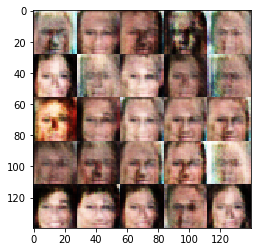

Epoch 1/1 step 1500... Discriminator Loss: 1.1512... Generator Loss: 1.1838
Epoch 1/1 step 1501... Discriminator Loss: 1.2384... Generator Loss: 0.8792
Epoch 1/1 step 1502... Discriminator Loss: 1.2694... Generator Loss: 0.8875
Epoch 1/1 step 1503... Discriminator Loss: 1.3668... Generator Loss: 0.8762
Epoch 1/1 step 1504... Discriminator Loss: 1.2979... Generator Loss: 0.8582
Epoch 1/1 step 1505... Discriminator Loss: 1.4126... Generator Loss: 0.8118
Epoch 1/1 step 1506... Discriminator Loss: 1.3281... Generator Loss: 0.7383
Epoch 1/1 step 1507... Discriminator Loss: 1.2883... Generator Loss: 1.1033
Epoch 1/1 step 1508... Discriminator Loss: 1.3712... Generator Loss: 0.6926
Epoch 1/1 step 1509... Discriminator Loss: 1.2938... Generator Loss: 1.0211
Epoch 1/1 step 1510... Discriminator Loss: 1.2291... Generator Loss: 0.8627
Epoch 1/1 step 1511... Discriminator Loss: 1.2082... Generator Loss: 0.8859
Epoch 1/1 step 1512... Discriminator Loss: 1.2284... Generator Loss: 1.0582
Epoch 1/1 st

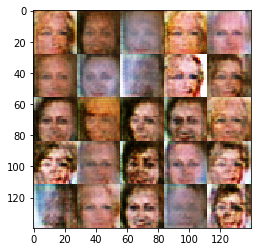

Epoch 1/1 step 1600... Discriminator Loss: 1.1857... Generator Loss: 1.2474
Epoch 1/1 step 1601... Discriminator Loss: 1.3612... Generator Loss: 0.6114
Epoch 1/1 step 1602... Discriminator Loss: 1.2985... Generator Loss: 1.4431
Epoch 1/1 step 1603... Discriminator Loss: 1.3727... Generator Loss: 0.5700
Epoch 1/1 step 1604... Discriminator Loss: 1.1616... Generator Loss: 1.0844
Epoch 1/1 step 1605... Discriminator Loss: 1.2312... Generator Loss: 0.7424
Epoch 1/1 step 1606... Discriminator Loss: 1.1031... Generator Loss: 1.0698
Epoch 1/1 step 1607... Discriminator Loss: 1.2855... Generator Loss: 0.9223
Epoch 1/1 step 1608... Discriminator Loss: 1.4607... Generator Loss: 0.9132
Epoch 1/1 step 1609... Discriminator Loss: 1.1994... Generator Loss: 0.9391
Epoch 1/1 step 1610... Discriminator Loss: 1.3597... Generator Loss: 0.6429
Epoch 1/1 step 1611... Discriminator Loss: 1.2911... Generator Loss: 0.8956
Epoch 1/1 step 1612... Discriminator Loss: 1.2863... Generator Loss: 1.4769
Epoch 1/1 st

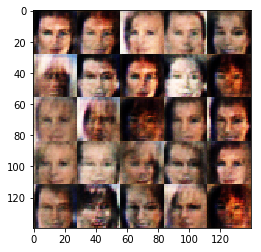

Epoch 1/1 step 1700... Discriminator Loss: 1.2579... Generator Loss: 0.8760
Epoch 1/1 step 1701... Discriminator Loss: 1.2178... Generator Loss: 0.9244
Epoch 1/1 step 1702... Discriminator Loss: 1.2541... Generator Loss: 0.8878
Epoch 1/1 step 1703... Discriminator Loss: 1.2525... Generator Loss: 0.8507
Epoch 1/1 step 1704... Discriminator Loss: 1.2350... Generator Loss: 0.9930
Epoch 1/1 step 1705... Discriminator Loss: 1.2550... Generator Loss: 0.8071
Epoch 1/1 step 1706... Discriminator Loss: 1.2214... Generator Loss: 0.9346
Epoch 1/1 step 1707... Discriminator Loss: 1.2716... Generator Loss: 0.9112
Epoch 1/1 step 1708... Discriminator Loss: 1.3382... Generator Loss: 0.8710
Epoch 1/1 step 1709... Discriminator Loss: 1.4582... Generator Loss: 0.5776
Epoch 1/1 step 1710... Discriminator Loss: 1.2742... Generator Loss: 1.3391
Epoch 1/1 step 1711... Discriminator Loss: 1.4476... Generator Loss: 0.5987
Epoch 1/1 step 1712... Discriminator Loss: 1.3384... Generator Loss: 1.2360
Epoch 1/1 st

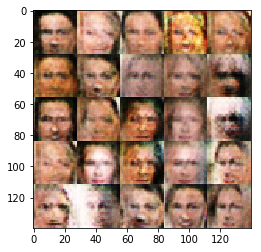

Epoch 1/1 step 1800... Discriminator Loss: 1.2568... Generator Loss: 0.8509
Epoch 1/1 step 1801... Discriminator Loss: 1.5001... Generator Loss: 0.5446
Epoch 1/1 step 1802... Discriminator Loss: 1.3870... Generator Loss: 1.8060
Epoch 1/1 step 1803... Discriminator Loss: 1.5745... Generator Loss: 0.4429
Epoch 1/1 step 1804... Discriminator Loss: 1.1956... Generator Loss: 1.3855
Epoch 1/1 step 1805... Discriminator Loss: 1.2709... Generator Loss: 0.7999
Epoch 1/1 step 1806... Discriminator Loss: 1.3405... Generator Loss: 0.7937
Epoch 1/1 step 1807... Discriminator Loss: 1.2420... Generator Loss: 0.9687
Epoch 1/1 step 1808... Discriminator Loss: 1.2300... Generator Loss: 0.7416
Epoch 1/1 step 1809... Discriminator Loss: 1.0914... Generator Loss: 1.0750
Epoch 1/1 step 1810... Discriminator Loss: 1.2572... Generator Loss: 1.1390
Epoch 1/1 step 1811... Discriminator Loss: 1.2247... Generator Loss: 0.7310
Epoch 1/1 step 1812... Discriminator Loss: 1.2587... Generator Loss: 1.1400
Epoch 1/1 st

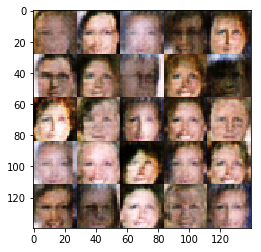

Epoch 1/1 step 1900... Discriminator Loss: 1.2046... Generator Loss: 0.8743
Epoch 1/1 step 1901... Discriminator Loss: 1.2896... Generator Loss: 0.7511
Epoch 1/1 step 1902... Discriminator Loss: 1.2147... Generator Loss: 1.0816
Epoch 1/1 step 1903... Discriminator Loss: 1.2523... Generator Loss: 0.7047
Epoch 1/1 step 1904... Discriminator Loss: 1.2608... Generator Loss: 1.2457
Epoch 1/1 step 1905... Discriminator Loss: 1.4002... Generator Loss: 0.5770
Epoch 1/1 step 1906... Discriminator Loss: 1.3277... Generator Loss: 0.8429
Epoch 1/1 step 1907... Discriminator Loss: 1.3553... Generator Loss: 0.8241
Epoch 1/1 step 1908... Discriminator Loss: 1.3074... Generator Loss: 0.9130
Epoch 1/1 step 1909... Discriminator Loss: 1.4082... Generator Loss: 0.8020
Epoch 1/1 step 1910... Discriminator Loss: 1.2841... Generator Loss: 0.7736
Epoch 1/1 step 1911... Discriminator Loss: 1.3508... Generator Loss: 0.9702
Epoch 1/1 step 1912... Discriminator Loss: 1.2155... Generator Loss: 1.0692
Epoch 1/1 st

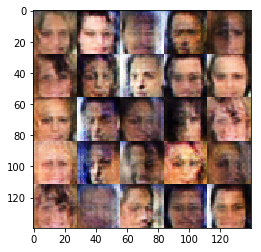

Epoch 1/1 step 2000... Discriminator Loss: 1.2386... Generator Loss: 0.7945
Epoch 1/1 step 2001... Discriminator Loss: 1.2684... Generator Loss: 0.9448
Epoch 1/1 step 2002... Discriminator Loss: 1.3193... Generator Loss: 0.7608
Epoch 1/1 step 2003... Discriminator Loss: 1.2661... Generator Loss: 0.8437
Epoch 1/1 step 2004... Discriminator Loss: 1.1587... Generator Loss: 1.0266
Epoch 1/1 step 2005... Discriminator Loss: 1.2646... Generator Loss: 0.7784
Epoch 1/1 step 2006... Discriminator Loss: 1.2631... Generator Loss: 1.3582
Epoch 1/1 step 2007... Discriminator Loss: 1.4209... Generator Loss: 0.5526
Epoch 1/1 step 2008... Discriminator Loss: 1.3961... Generator Loss: 1.3181
Epoch 1/1 step 2009... Discriminator Loss: 1.5900... Generator Loss: 0.4275
Epoch 1/1 step 2010... Discriminator Loss: 1.5780... Generator Loss: 1.6891
Epoch 1/1 step 2011... Discriminator Loss: 1.4041... Generator Loss: 0.5220
Epoch 1/1 step 2012... Discriminator Loss: 1.2669... Generator Loss: 1.1075
Epoch 1/1 st

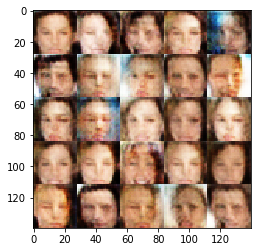

Epoch 1/1 step 2100... Discriminator Loss: 1.3673... Generator Loss: 0.7489
Epoch 1/1 step 2101... Discriminator Loss: 1.3838... Generator Loss: 1.0334
Epoch 1/1 step 2102... Discriminator Loss: 1.3663... Generator Loss: 0.5666
Epoch 1/1 step 2103... Discriminator Loss: 1.5964... Generator Loss: 2.0838
Epoch 1/1 step 2104... Discriminator Loss: 1.6235... Generator Loss: 0.4051
Epoch 1/1 step 2105... Discriminator Loss: 1.3237... Generator Loss: 0.9889
Epoch 1/1 step 2106... Discriminator Loss: 1.3116... Generator Loss: 1.0076
Epoch 1/1 step 2107... Discriminator Loss: 1.3216... Generator Loss: 0.6882
Epoch 1/1 step 2108... Discriminator Loss: 1.4191... Generator Loss: 0.7623
Epoch 1/1 step 2109... Discriminator Loss: 1.2762... Generator Loss: 0.8484
Epoch 1/1 step 2110... Discriminator Loss: 1.2539... Generator Loss: 1.0663
Epoch 1/1 step 2111... Discriminator Loss: 1.3365... Generator Loss: 0.5866
Epoch 1/1 step 2112... Discriminator Loss: 1.1611... Generator Loss: 1.0607
Epoch 1/1 st

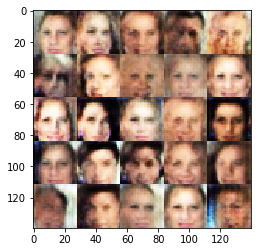

Epoch 1/1 step 2200... Discriminator Loss: 1.1406... Generator Loss: 1.0398
Epoch 1/1 step 2201... Discriminator Loss: 1.3076... Generator Loss: 0.8677
Epoch 1/1 step 2202... Discriminator Loss: 1.2782... Generator Loss: 0.8107
Epoch 1/1 step 2203... Discriminator Loss: 1.2856... Generator Loss: 1.0679
Epoch 1/1 step 2204... Discriminator Loss: 1.3141... Generator Loss: 0.6946
Epoch 1/1 step 2205... Discriminator Loss: 1.1574... Generator Loss: 1.1797
Epoch 1/1 step 2206... Discriminator Loss: 1.1728... Generator Loss: 0.9138
Epoch 1/1 step 2207... Discriminator Loss: 1.3044... Generator Loss: 0.7257
Epoch 1/1 step 2208... Discriminator Loss: 1.3814... Generator Loss: 0.8304
Epoch 1/1 step 2209... Discriminator Loss: 1.3501... Generator Loss: 0.8190
Epoch 1/1 step 2210... Discriminator Loss: 1.2521... Generator Loss: 0.9666
Epoch 1/1 step 2211... Discriminator Loss: 1.2227... Generator Loss: 1.0229
Epoch 1/1 step 2212... Discriminator Loss: 1.3123... Generator Loss: 0.7435
Epoch 1/1 st

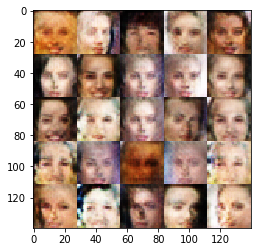

Epoch 1/1 step 2300... Discriminator Loss: 1.7359... Generator Loss: 0.3401
Epoch 1/1 step 2301... Discriminator Loss: 1.4221... Generator Loss: 1.6062
Epoch 1/1 step 2302... Discriminator Loss: 1.2388... Generator Loss: 0.8138
Epoch 1/1 step 2303... Discriminator Loss: 1.3033... Generator Loss: 0.6836
Epoch 1/1 step 2304... Discriminator Loss: 1.2317... Generator Loss: 1.0477
Epoch 1/1 step 2305... Discriminator Loss: 1.3308... Generator Loss: 0.8599
Epoch 1/1 step 2306... Discriminator Loss: 1.2870... Generator Loss: 0.8753
Epoch 1/1 step 2307... Discriminator Loss: 1.2382... Generator Loss: 0.8847
Epoch 1/1 step 2308... Discriminator Loss: 1.2246... Generator Loss: 1.0985
Epoch 1/1 step 2309... Discriminator Loss: 1.2760... Generator Loss: 0.7060
Epoch 1/1 step 2310... Discriminator Loss: 1.2945... Generator Loss: 1.0010
Epoch 1/1 step 2311... Discriminator Loss: 1.2367... Generator Loss: 1.0892
Epoch 1/1 step 2312... Discriminator Loss: 1.3099... Generator Loss: 0.6812
Epoch 1/1 st

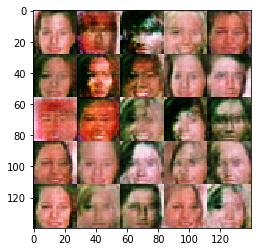

Epoch 1/1 step 2400... Discriminator Loss: 1.2398... Generator Loss: 1.1024
Epoch 1/1 step 2401... Discriminator Loss: 1.4781... Generator Loss: 0.5200
Epoch 1/1 step 2402... Discriminator Loss: 1.4019... Generator Loss: 1.5352
Epoch 1/1 step 2403... Discriminator Loss: 1.3378... Generator Loss: 0.6007
Epoch 1/1 step 2404... Discriminator Loss: 1.2884... Generator Loss: 0.9281
Epoch 1/1 step 2405... Discriminator Loss: 1.2179... Generator Loss: 1.2915
Epoch 1/1 step 2406... Discriminator Loss: 1.4019... Generator Loss: 0.5652
Epoch 1/1 step 2407... Discriminator Loss: 1.2515... Generator Loss: 1.4335
Epoch 1/1 step 2408... Discriminator Loss: 1.2646... Generator Loss: 0.7633
Epoch 1/1 step 2409... Discriminator Loss: 1.2152... Generator Loss: 0.8706
Epoch 1/1 step 2410... Discriminator Loss: 1.1388... Generator Loss: 1.0938
Epoch 1/1 step 2411... Discriminator Loss: 1.0988... Generator Loss: 0.9431
Epoch 1/1 step 2412... Discriminator Loss: 1.1727... Generator Loss: 1.0274
Epoch 1/1 st

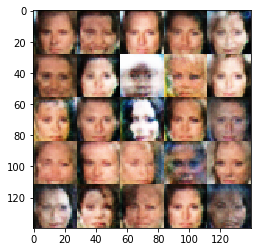

Epoch 1/1 step 2500... Discriminator Loss: 1.1433... Generator Loss: 0.8885
Epoch 1/1 step 2501... Discriminator Loss: 1.2296... Generator Loss: 1.0829
Epoch 1/1 step 2502... Discriminator Loss: 1.2690... Generator Loss: 0.7330
Epoch 1/1 step 2503... Discriminator Loss: 1.3531... Generator Loss: 0.8690
Epoch 1/1 step 2504... Discriminator Loss: 1.2738... Generator Loss: 0.9521
Epoch 1/1 step 2505... Discriminator Loss: 1.2713... Generator Loss: 0.8449
Epoch 1/1 step 2506... Discriminator Loss: 1.2108... Generator Loss: 1.0424
Epoch 1/1 step 2507... Discriminator Loss: 1.0674... Generator Loss: 0.9116
Epoch 1/1 step 2508... Discriminator Loss: 1.2434... Generator Loss: 0.8222
Epoch 1/1 step 2509... Discriminator Loss: 1.2491... Generator Loss: 1.2648
Epoch 1/1 step 2510... Discriminator Loss: 1.3056... Generator Loss: 0.6100
Epoch 1/1 step 2511... Discriminator Loss: 1.2953... Generator Loss: 0.8711
Epoch 1/1 step 2512... Discriminator Loss: 1.3319... Generator Loss: 0.7746
Epoch 1/1 st

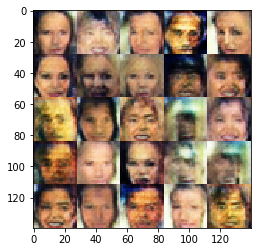

Epoch 1/1 step 2600... Discriminator Loss: 1.3078... Generator Loss: 0.6799
Epoch 1/1 step 2601... Discriminator Loss: 1.2560... Generator Loss: 0.9712
Epoch 1/1 step 2602... Discriminator Loss: 1.2225... Generator Loss: 0.8331
Epoch 1/1 step 2603... Discriminator Loss: 1.2735... Generator Loss: 0.9168
Epoch 1/1 step 2604... Discriminator Loss: 1.3365... Generator Loss: 0.7799
Epoch 1/1 step 2605... Discriminator Loss: 1.1809... Generator Loss: 0.9403
Epoch 1/1 step 2606... Discriminator Loss: 1.1345... Generator Loss: 0.8532
Epoch 1/1 step 2607... Discriminator Loss: 1.2182... Generator Loss: 1.0854
Epoch 1/1 step 2608... Discriminator Loss: 1.2519... Generator Loss: 0.7324
Epoch 1/1 step 2609... Discriminator Loss: 1.2913... Generator Loss: 1.3524
Epoch 1/1 step 2610... Discriminator Loss: 1.5416... Generator Loss: 0.4352
Epoch 1/1 step 2611... Discriminator Loss: 1.3801... Generator Loss: 1.6330
Epoch 1/1 step 2612... Discriminator Loss: 1.4061... Generator Loss: 0.5783
Epoch 1/1 st

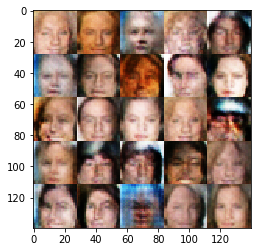

Epoch 1/1 step 2700... Discriminator Loss: 1.1589... Generator Loss: 0.8578
Epoch 1/1 step 2701... Discriminator Loss: 1.2261... Generator Loss: 1.1712
Epoch 1/1 step 2702... Discriminator Loss: 1.1824... Generator Loss: 0.8145
Epoch 1/1 step 2703... Discriminator Loss: 1.3467... Generator Loss: 0.7094
Epoch 1/1 step 2704... Discriminator Loss: 1.4061... Generator Loss: 0.9954
Epoch 1/1 step 2705... Discriminator Loss: 1.3410... Generator Loss: 0.8993
Epoch 1/1 step 2706... Discriminator Loss: 1.2710... Generator Loss: 0.7431
Epoch 1/1 step 2707... Discriminator Loss: 1.3404... Generator Loss: 0.9206
Epoch 1/1 step 2708... Discriminator Loss: 1.2779... Generator Loss: 0.9700
Epoch 1/1 step 2709... Discriminator Loss: 1.2646... Generator Loss: 0.7431
Epoch 1/1 step 2710... Discriminator Loss: 1.3469... Generator Loss: 0.9298
Epoch 1/1 step 2711... Discriminator Loss: 1.3461... Generator Loss: 0.7979
Epoch 1/1 step 2712... Discriminator Loss: 1.2891... Generator Loss: 0.7936
Epoch 1/1 st

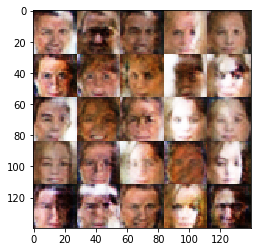

Epoch 1/1 step 2800... Discriminator Loss: 1.2975... Generator Loss: 0.9491
Epoch 1/1 step 2801... Discriminator Loss: 1.2607... Generator Loss: 0.8876
Epoch 1/1 step 2802... Discriminator Loss: 1.2095... Generator Loss: 0.8330
Epoch 1/1 step 2803... Discriminator Loss: 1.1417... Generator Loss: 1.1417
Epoch 1/1 step 2804... Discriminator Loss: 1.3048... Generator Loss: 0.7973
Epoch 1/1 step 2805... Discriminator Loss: 1.1777... Generator Loss: 1.1521
Epoch 1/1 step 2806... Discriminator Loss: 1.2588... Generator Loss: 0.7130
Epoch 1/1 step 2807... Discriminator Loss: 1.2409... Generator Loss: 1.1881
Epoch 1/1 step 2808... Discriminator Loss: 1.2714... Generator Loss: 0.7368
Epoch 1/1 step 2809... Discriminator Loss: 1.1561... Generator Loss: 1.1147
Epoch 1/1 step 2810... Discriminator Loss: 1.2462... Generator Loss: 0.8521
Epoch 1/1 step 2811... Discriminator Loss: 1.3022... Generator Loss: 0.8158
Epoch 1/1 step 2812... Discriminator Loss: 1.2931... Generator Loss: 0.8243
Epoch 1/1 st

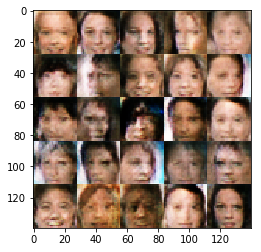

Epoch 1/1 step 2900... Discriminator Loss: 1.2085... Generator Loss: 1.1480
Epoch 1/1 step 2901... Discriminator Loss: 1.1214... Generator Loss: 0.8724
Epoch 1/1 step 2902... Discriminator Loss: 1.1493... Generator Loss: 0.9042
Epoch 1/1 step 2903... Discriminator Loss: 1.2175... Generator Loss: 0.9227
Epoch 1/1 step 2904... Discriminator Loss: 1.2161... Generator Loss: 0.9590
Epoch 1/1 step 2905... Discriminator Loss: 1.3084... Generator Loss: 0.7754
Epoch 1/1 step 2906... Discriminator Loss: 1.3624... Generator Loss: 0.9519
Epoch 1/1 step 2907... Discriminator Loss: 1.4122... Generator Loss: 0.6784
Epoch 1/1 step 2908... Discriminator Loss: 1.2506... Generator Loss: 1.2879
Epoch 1/1 step 2909... Discriminator Loss: 1.2408... Generator Loss: 0.7905
Epoch 1/1 step 2910... Discriminator Loss: 1.1856... Generator Loss: 1.1238
Epoch 1/1 step 2911... Discriminator Loss: 1.2305... Generator Loss: 1.0389
Epoch 1/1 step 2912... Discriminator Loss: 1.1217... Generator Loss: 0.7642
Epoch 1/1 st

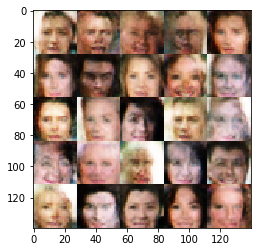

Epoch 1/1 step 3000... Discriminator Loss: 1.3412... Generator Loss: 0.5892
Epoch 1/1 step 3001... Discriminator Loss: 1.4240... Generator Loss: 1.4742
Epoch 1/1 step 3002... Discriminator Loss: 1.4328... Generator Loss: 0.4684
Epoch 1/1 step 3003... Discriminator Loss: 1.4588... Generator Loss: 1.4309
Epoch 1/1 step 3004... Discriminator Loss: 1.4053... Generator Loss: 0.5731
Epoch 1/1 step 3005... Discriminator Loss: 1.3593... Generator Loss: 1.0085
Epoch 1/1 step 3006... Discriminator Loss: 1.2934... Generator Loss: 0.7521
Epoch 1/1 step 3007... Discriminator Loss: 1.4158... Generator Loss: 0.6390
Epoch 1/1 step 3008... Discriminator Loss: 1.2589... Generator Loss: 1.1348
Epoch 1/1 step 3009... Discriminator Loss: 1.2930... Generator Loss: 0.6908
Epoch 1/1 step 3010... Discriminator Loss: 1.2869... Generator Loss: 0.9484
Epoch 1/1 step 3011... Discriminator Loss: 1.3284... Generator Loss: 0.9159
Epoch 1/1 step 3012... Discriminator Loss: 1.3633... Generator Loss: 0.6839
Epoch 1/1 st

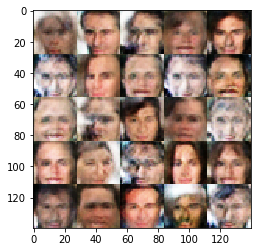

Epoch 1/1 step 3100... Discriminator Loss: 1.3292... Generator Loss: 0.6921
Epoch 1/1 step 3101... Discriminator Loss: 1.2599... Generator Loss: 0.9251
Epoch 1/1 step 3102... Discriminator Loss: 1.3483... Generator Loss: 0.8318
Epoch 1/1 step 3103... Discriminator Loss: 1.3060... Generator Loss: 0.7738
Epoch 1/1 step 3104... Discriminator Loss: 1.2183... Generator Loss: 0.9639
Epoch 1/1 step 3105... Discriminator Loss: 1.2419... Generator Loss: 0.7717
Epoch 1/1 step 3106... Discriminator Loss: 1.1145... Generator Loss: 0.9145
Epoch 1/1 step 3107... Discriminator Loss: 1.1836... Generator Loss: 0.9081
Epoch 1/1 step 3108... Discriminator Loss: 1.2182... Generator Loss: 0.7749
Epoch 1/1 step 3109... Discriminator Loss: 1.2385... Generator Loss: 0.9427
Epoch 1/1 step 3110... Discriminator Loss: 1.3162... Generator Loss: 0.7337
Epoch 1/1 step 3111... Discriminator Loss: 1.2566... Generator Loss: 0.9829
Epoch 1/1 step 3112... Discriminator Loss: 1.4044... Generator Loss: 0.7211
Epoch 1/1 st

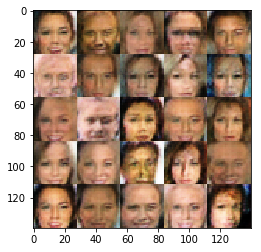

In [56]:
batch_size = 64
z_dim = 50
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.